In [1]:
import numpy as np

import sys

sys.path.append("../")

from src.futbol_types import TransitionMatrix


In [2]:
R_storage = np.load("R_storage.npy")
R_storage.shape

(380, 2, 4, 15, 15)

In [4]:
from src.utils_CTMC import build_Q

Q_storage = np.zeros(R_storage.shape)

for pi in range(R_storage.shape[0]):
    for ti in range(R_storage.shape[1]):
        for li in range(R_storage.shape[2]):
            if np.sum(R_storage[pi, ti, li, :]) != 0:
                Q_storage[pi, ti, li, :] = build_Q(R_storage[pi, ti, li, :])

In [5]:
from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

In [6]:
from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_lineup_duration


lineup_durations = np.zeros(R_storage.shape[:-2])
partidos = separar_partidos(epl)
for pi, partido in enumerate(partidos):
     for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
                    lineup_durations[pi, ti, li] = get_lineup_duration(lineup)

In [7]:
from src.utils_CTMC import psl_estimator

psls = np.zeros(R_storage.shape[:2])
print(psls.shape)

for pi, partido in enumerate(partidos):
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        ti_psls = []
        li_durs = []
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            # In R_storage[pi, ti, li, 0, :] we have the ids of the players in the lineup
            Q = Q_storage[pi, ti, li, 1:, 1:]
            psl = psl_estimator(Q)
            ti_psls.append(psl)
            li_durs.append(get_lineup_duration(lineup))

        psls[pi, ti] = np.average(ti_psls, weights=li_durs)

(380, 2)


In [11]:
R_storage[0, 0, 0, 0, :]

array([    0.,     0., 17733., 19524., 15943., 20467., 80254.,  8758.,
       42427., 17127., 43274., 28566., 59936.,     0.,     0.])

In [20]:
from src.epl_player_data_utils import EPLPlayerData


epl_player_json_path = "../SampleData/players.json"
epl_player_data = EPLPlayerData(epl_player_json_path)
sample_player_id = epl_player_data.get_player_id_by_lastname("Agüero")
sample_player_id

'p37572'

In [46]:
# Find the R_storage[ti, li, :, :, :] in wich Agüero is present
durations = {}
sample_player_id = 37572
for pi in range(R_storage.shape[0]):
    for ti in range(R_storage.shape[1]):

        if (pi, ti) in durations:
            continue

        for li in range(R_storage.shape[2]):
            if sample_player_id in R_storage[pi, ti, li, 0, :]:
                durations[(pi, ti)] = lineup_durations[pi, ti, :]
                break


In [57]:
# Player Weighting

# For each lineup in which Agüero is present, we will calculate the PSL
# But the q value in wich sample_player is present will be weighted by an alpha value [0, 1] every 0.1

from src.utils_CTMC import psl_estimator

alpha_values = np.array(range(0, 10, 1)) / 10

weighted_psls_matches = {}
for pi, ti in durations.keys():
    weighted_psls = []
    for alpha in alpha_values:
        psls = []
        durs = []
        for li in range(R_storage.shape[2]):
            if sample_player_id in R_storage[pi, ti, li, 0, :]:
                sample_player_id_pos = np.where(R_storage[pi, ti, li, 0, :] == sample_player_id)[0][0]
                Q = Q_storage[pi, ti, li, :, :]
                Q[sample_player_id_pos, :] = alpha * Q[sample_player_id_pos, :]
                Q[:, sample_player_id_pos] = alpha * Q[:, sample_player_id_pos]
                psl = psl_estimator(Q[1:, 1:])
                psls.append(psl)
                durs.append(lineup_durations[pi, ti, li])
        weighted_psls.append(
            (np.average(psls, weights=durs), alpha)
        )

    weighted_psls_matches[(pi, ti)] = weighted_psls

In [43]:
import matplotlib.pyplot as plt

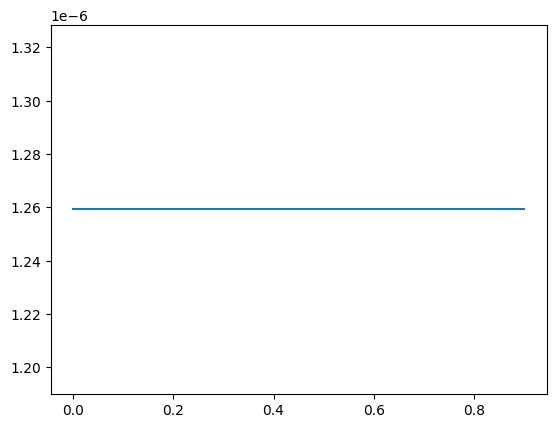

In [58]:
# Sample (pi, ti) with the best PSL when alpha = 0
max_psl = -1
max_psl_match = None
for match, weighted_psls in weighted_psls_matches.items():
    if weighted_psls[0][0] > max_psl:
        max_psl = weighted_psls[0][0]
        max_psl_match = match

weighted_psls_sample = weighted_psls_matches[max_psl_match]

fig, ax = plt.subplots()

ax.plot(alpha_values, [x[0] for x in weighted_psls_sample])


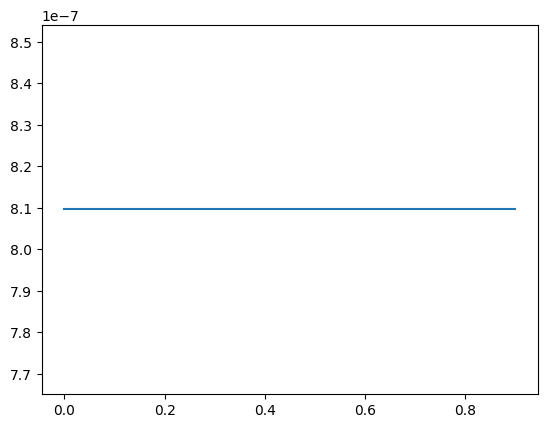

In [49]:
# Sample (pi, ti) with the most variance in PSL when alpha changes
max_var = -1
max_var_match = None

for match, weighted_psls in weighted_psls_matches.items():
    psls = [x[0] for x in weighted_psls]
    var = np.var(psls)
    if var > max_var:
        max_var = var
        max_var_match = match

weighted_psls_sample = weighted_psls_matches[max_var_match]

fig, ax = plt.subplots()

ax.plot(alpha_values, [x[0] for x in weighted_psls_sample])


In [77]:
R_storage[0, 0, 0, 1:, 1:].shape

(14, 14)

In [86]:
# Dataset for target: q(p, S)

shots_dataset = []

for pi, partido in enumerate(partidos):
    match_id = partido["match_id"].values[0]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R = R_storage[pi, ti, li, 1:, 1:]
            players = R_storage[pi, ti, li, 0, :]
            for player_id in players:
                player_pos = np.where(players == player_id)[0][0]
                
                # Value in R[player_pos, 13] is the ratio of shots to time played for player_id
                shots_dataset.append({
                    "player_id": player_id,
                    "team_id": ti,
                    "match_id": match_id,
                    "match_num": pi,
                    "lineup_id": li,
                    "shots_ratio": R[player_pos, 13]
                })
            

In [80]:
import pandas as pd

In [87]:
s_ds = pd.DataFrame(shots_dataset)
s_ds

,player_id,team_id,match_id,match_num,lineup_id,shots_ratio
0,0.0,0,441999,0,0,0.000000
1,0.0,0,441999,0,0,0.000000
2,17733.0,0,441999,0,0,0.032249
3,19524.0,0,441999,0,0,0.016125
4,15943.0,0,441999,0,0,0.016125
...,...,...,...,...,...,...
41920,76227.0,1,442378,379,3,0.000000
41921,50471.0,1,442378,379,3,0.000000
41922,125510.0,1,442378,379,3,0.000000
41923,0.0,1,442378,379,3,0.000000


In [88]:
s_ds.to_csv("shots_dataset.csv", index=False)